# ISSA BACHIR
# M2 IABD
# SN TENSORFLOW

In [43]:
#  Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report


In [44]:
# Préparation du dataset (division en train/val)
data_dir = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
splitfolders.ratio(data_dir,output='dataset',seed=555,ratio=(.8,.2))
print("✅ Dataset divisé en Train/Validation.")




Copying files: 12446 files [01:10, 177.56 files/s]

✅ Dataset divisé en Train/Validation.


In [45]:
# generation de l'image
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,zoom_range=0.2, horizontal_flip =True)
valid_datagen = ImageDataGenerator(rescale=1./255)


In [46]:
training_set= train_datagen.flow_from_directory(
    'dataset/train',target_size=(64,64),batch_size=32,class_mode = 'categorical')
valid_set = valid_datagen.flow_from_directory(
    'dataset/val',target_size=(64,64),batch_size=32, class_mode='categorical')

print("✅ Génération d'images terminée.")

Found 9955 images belonging to 4 classes.
Found 3736 images belonging to 4 classes.
✅ Génération d'images terminée.


In [47]:
#Construction CNN
classifier = Sequential()
classifier.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(64,64,3),activation='relu'))
classifier.add(MaxPooling2D(2,2))
classifier.add(Conv2D(64,(3,3),activation='relu'))
classifier.add(MaxPooling2D(2,2))
classifier.add(Dropout(0.2))
classifier.add(Conv2D(128,(3,3),activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(2,2))
classifier.add(Flatten())
classifier.add(Dropout(0.3))
classifier.add(Dense(512,activation ='relu'))
classifier.add(Dense(4,activation ='softmax'))


In [48]:
# Compilation du modèle
classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0005 * 0.9 ** epoch)
#Le LearningRateScheduler permet de réduire progressivement le learning rate (taux d’apprentissage) au fil des époques. 



In [49]:
# Paramètres d'optimisation
checkpointer = ModelCheckpoint(filepath='checkpoints/models.keras', monitor="val_accuracy",
                               mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.2, patience=2, min_lr=0.0001)

callbacks = [checkpointer, early_stopping, reduce_lr,lr_scheduler]


In [50]:
# Affichage du résumé du modèle
classifier.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,455,620 (9.37 MB)

 Trainable params: 2,455,364 (9.37 MB)

 Non-trainable params: 256 (1.00 KB)

In [51]:
# Avoir les diferentes classes
training_set.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

In [52]:
# Entraînement du modèle
model = classifier.fit(training_set, validation_data=valid_set, epochs=10, verbose=1, callbacks=callbacks)


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.6608 - loss: 0.9808
Epoch 1: val_accuracy improved from -inf to 0.88169, saving model to checkpoints/models.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 315s 992ms/step - accuracy: 0.6611 - loss: 0.9798 - val_accuracy: 0.8817 - val_loss: 0.7057 - learning_rate: 5.0000e-04
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8999 - loss: 0.2670
Epoch 2: val_accuracy improved from 0.88169 to 0.88276, saving model to checkpoints/models.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 143s 458ms/step - accuracy: 0.8999 - loss: 0.2669 - val_accuracy: 0.8828 - val_loss: 0.3100 - learning_rate: 4.5000e-04
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9512 - loss: 0.1369
Epoch 3: val_accuracy improved from 0.88276 to 0.91729, saving model to checkpoints/models.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 141s 451ms/step - accuracy: 0.9512 - loss: 0.1369 - val_accuracy: 0.9173 - val_loss: 0.2488 - learning_rate: 4.0500e-04
E

In [53]:
# Sauvegarde du modèle
classifier.save("kidney_model.h5")
print("✅ Modèle sauvegardé sous le nom 'kidney_model.h5'.")

✅ Modèle sauvegardé sous le nom 'kidney_model.h5'.


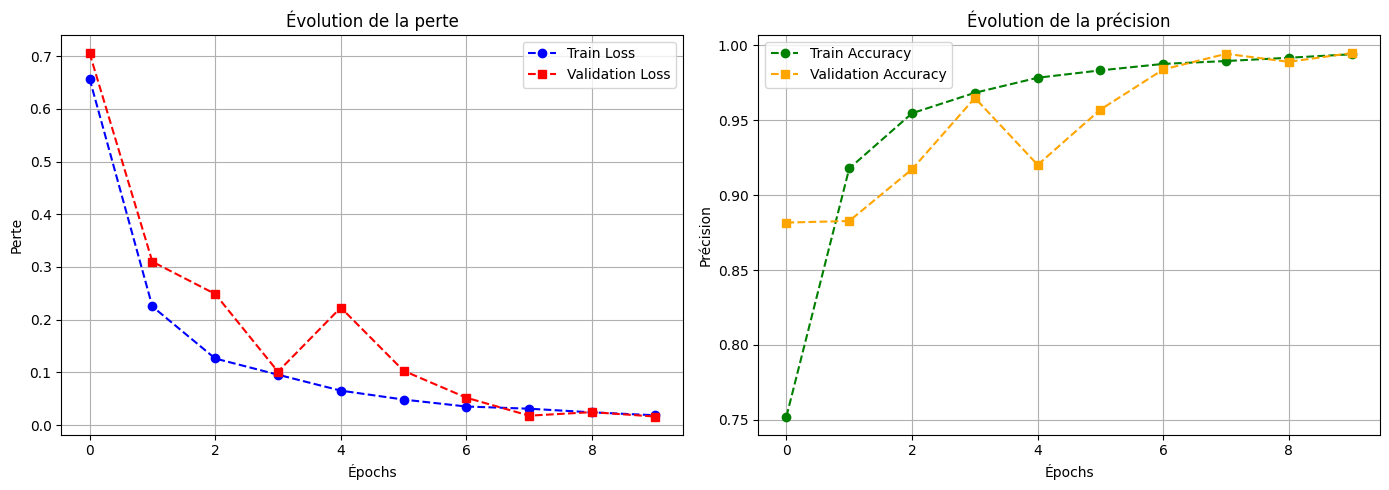

In [ ]:
# Affichage des courbes de performance
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
#  Courbe de perte
ax[0].plot(model.history['loss'], label='Train Loss', color='blue', linestyle='dashed', marker='o')
ax[0].plot(model.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed', marker='s')
ax[0].set_title('Évolution de la perte')
ax[0].set_xlabel('Épochs')
ax[0].set_ylabel('Perte')
ax[0].legend()
ax[0].grid(True)
#  Courbe de précision
ax[1].plot(model.history['accuracy'], label='Train Accuracy', color='green', linestyle='dashed', marker='o')
ax[1].plot(model.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='dashed', marker='s')
ax[1].set_title('Évolution de la précision')
ax[1].set_xlabel('Épochs')
ax[1].set_ylabel('Précision')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

312/312 ━━━━━━━━━━━━━━━━━━━━ 92s 292ms/step


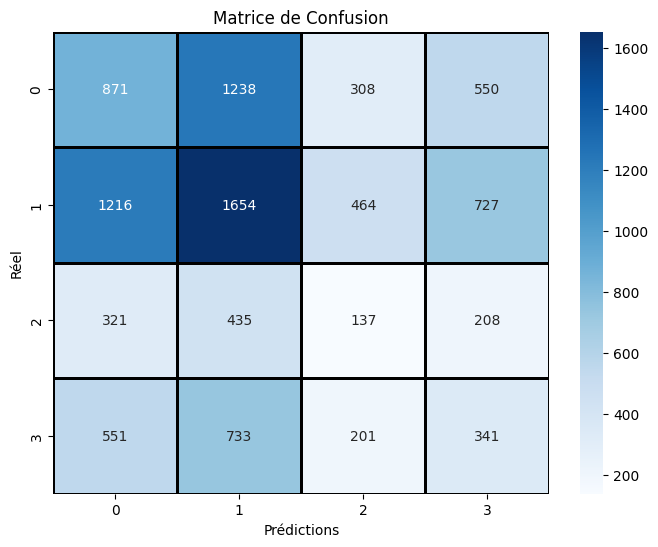

In [55]:
# Matrice de confusion
y_pred = classifier.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)

cnf_metric = confusion_matrix(training_set.classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cnf_metric, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

In [56]:
#  Rapport de classification
print("Rapport de classification :")
print(classification_report(training_set.classes, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.29      0.29      0.29      2967
           1       0.41      0.41      0.41      4061
           2       0.12      0.12      0.12      1101
           3       0.19      0.19      0.19      1826

    accuracy                           0.30      9955
   macro avg       0.25      0.25      0.25      9955
weighted avg       0.30      0.30      0.30      9955

